In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from time import time
import json
import sys

from thorr.utils import read_config

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.inspection import permutation_importance

from joblib import dump, load

from permetrics.regression import RegressionMetric

In [2]:
config_path = Path('/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/03-HAB/.env/hab_config.ini')
config_dict = read_config(config_path)
project_dir = Path(config_dict["project"]["project_dir"])

In [3]:
# global parameters
seed = 1955
test_size = 0.2
list_metrics = ["RMSE", "MAE", "NSE", "R2", "KGE", "MSE"]

# Cross-validation parameters
n_splits = 5
n_repeats = 10

In [4]:
# define dictionary for tuning results
tuning_results = {metric: [] for metric in list_metrics}
tuning_results['hyperparameter'] = []
tuning_results['hypervalue'] = []
tuning_results['mission'] = []
tuning_results['set_type'] = []

tuning_results_df = pd.DataFrame(tuning_results)

In [4]:
hp_name = 'min_samples_leaf'
hp_values = [1] + list(range(10, 101, 10)) + list(range(125, 201, 25)) + list(range(250, 301, 25))

hyperparameters = {
    hp_name: hp_values,
}


## HLS Landsat

In [6]:
hlsl30_model_name = "rfr_hlsl30"

hlsl30_features = [
    # "b01_median",
    "b02_median",
    "b03_median",
    "b04_median",
    "b05_median",
    "b06_median",
    "b07_median",
    # "b09_median",
    "doy"
]
hlsl30_target = "log_chl_a"

In [ ]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter l30 data and select features + target
hlsl30_insitu = hls_insitu[hls_insitu['mission']=='l30'][
    [
        "Date",
        "StationID",
    ] + hlsl30_features + [hlsl30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlsl30_insitu.dropna(
    subset=hlsl30_features + [hlsl30_target],
    inplace=True,
    # how="all"
)
# shuffle l30 data
hlsl30_insitu = hlsl30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [1]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(**{hp: value, 'random_state': seed})

        cv_splitter = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlsl30_insitu):
            X_train = hlsl30_insitu.iloc[train_index][hlsl30_features]
            y_train = hlsl30_insitu.iloc[train_index][hlsl30_target]

            X_val = hlsl30_insitu.iloc[val_index][hlsl30_features]
            y_val = hlsl30_insitu.iloc[val_index][hlsl30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values,
                y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(
                y_true=y_val.values,
                y_pred=list(y_val_pred)
            )

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results['hyperparameter'].append(hp)
            tuning_results['hypervalue'].append(value)
            tuning_results['set_type'].append('train')
            tuning_results['mission'].append('l30')


            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results['hyperparameter'].append(hp)
            tuning_results['hypervalue'].append(value)
            tuning_results['set_type'].append('val')
            tuning_results['mission'].append('l30')

del hlsl30_insitu

NameError: name 'hyperparameters' is not defined

In [ ]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

del tuning_results_df

Text(0, 0.5, 'R2')

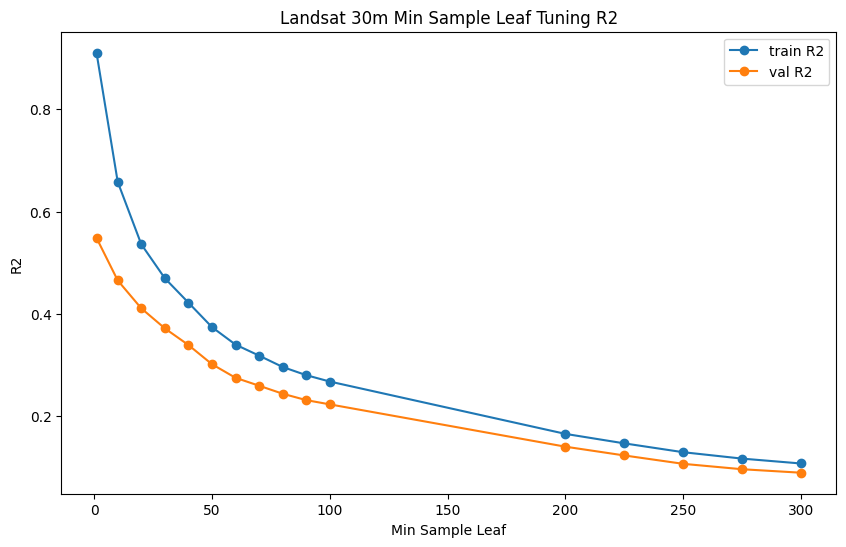

In [6]:
# plot the tuning results
tuning_results_df = pd.read_csv(f'{hp_name}_results.csv')

fig, ax = plt.subplots(figsize=(10, 6))
for set_type, group_data in tuning_results_df.groupby('set_type'):
    mean_rmse = group_data.groupby('hypervalue')['R2'].mean()
    ax.plot(
        mean_rmse.index,
        mean_rmse.values,
        marker='o',
        label=f'{set_type} R2'
    )

ax.legend()
ax.set_title('Landsat 30m Min Sample Leaf Tuning R2')
ax.set_xlabel('Min Sample Leaf')
ax.set_ylabel('R2')

## HLS Sentinel

In [ ]:
hlss30_model_name = "rfr_hlss30"

hlss30_features = [
    # "b01_median",
    "b02_median",
    "b03_median",
    "b04_median",
    "b05_median",
    # "b06_median",
    "b07_median",
    # "b08_median",
    "b8a_median",
    "b09_median",
    # "b10_median",
    # "b11_median",
    # "b12_median",
    "doy"
]
hlss30_target = "log_chl_a"

In [ ]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter s30 data and select features + target
hlss30_insitu = hls_insitu[hls_insitu['mission']=='s30'][
    [
        "Date",
        "StationID",
    ] + hlss30_features + [hlss30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlss30_insitu.dropna(
    subset=hlss30_features + [hlss30_target],
    inplace=True,
    # how="all"
)
# shuffle l30 data
hlss30_insitu = hlss30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [ ]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(**{hp: value, 'random_state': seed})

        cv_splitter = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlss30_insitu):
            X_train = hlss30_insitu.iloc[train_index][hlss30_features]
            y_train = hlss30_insitu.iloc[train_index][hlss30_target]

            X_val = hlss30_insitu.iloc[val_index][hlss30_features]
            y_val = hlss30_insitu.iloc[val_index][hlss30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values,
                y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(
                y_true=y_val.values,
                y_pred=list(y_val_pred)
            )

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results['hyperparameter'].append(hp)
            tuning_results['hypervalue'].append(value)
            tuning_results['set_type'].append('train')
            tuning_results['mission'].append('s30')


            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results['hyperparameter'].append(hp)
            tuning_results['hypervalue'].append(value)
            tuning_results['set_type'].append('val')
            tuning_results['mission'].append('s30')

del hlss30_insitu

In [ ]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

del tuning_results_df